In [1]:
%pylab inline
# %load_ext memory_profiler

import os
import time
import warnings

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel
import pygraphviz
from pomegranate import BayesianNetwork, NormalDistribution
from pomegranate.utils import plot_networkx
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error, precision_score, f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering, boxplot_clustering)
from src.models.k2 import k2, graph_from_dict
os.chdir('./notebooks')

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


# Aquisição dos dados

Segundo o artigo, eles usaram dados do índice iBobespa (**^IBOV**), entre 01/01/2020 e 01/07/2021.

In [86]:
# start_date = "2011-01-01"
# end_date = "2021-05-31"

start_date = "2021-01-01"
end_date = "2021-07-20"

# ticker = "iBovespa"
# ticker = "NYSE"
ticker = "Nikkey"

if ticker == "Nikkey":
    df_ticker = yf.download("^N225", start=start_date, end=end_date)
elif ticker == "iBovespa":
    df_ticker = yf.download('^BVSP', start=start_date, end=end_date)
elif ticker == "NYSE":
    df_ticker = yf.download('^NYA', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


Finding Elimination Order: : : 0it [06:19, ?it/s]
Finding Elimination Order: : : 0it [06:19, ?it/s]


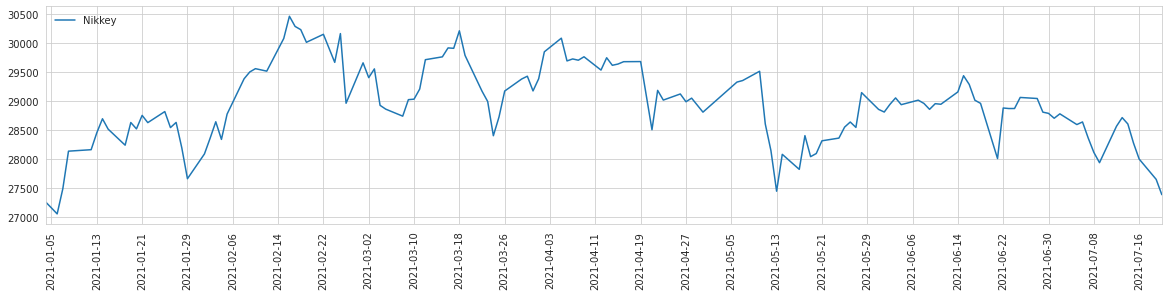

In [87]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ticker['Close'], label=ticker)

date_min = df_ticker.index.min()
date_max = df_ticker.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### IMPORTANTE!

Continuar somente com o Índice Nikkey 225, por enquanto. Pois não temos somente os dados da Toyota a partir de 1999.


## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (22/02/1985 até 30/11/2008) e de validação do modelo (01/12/2008 até 30/12/2008).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [88]:
df = df_ticker[["Close"]].copy()
df = daily_return(df)
df = create_shifted_rt(df, np.arange(1, 21, 2))
# df = uniform_clustering(df)
df = binary_clustering(df)
# df = boxplot_clustering(df)
# df = df[[column for column in df.columns if 'cluster_' in column]].copy()
df.dropna(how='any', axis=0, inplace=True)

for column in [column for column in df.columns if 'cluster_' in column]:
    df[column] = df[column].astype(int)

df.head()

,Close,rt-1,rt-3,rt-5,rt-7,rt-9,rt-11,rt-13,rt-15,rt-17,...,cluster_rt-1,cluster_rt-3,cluster_rt-5,cluster_rt-7,cluster_rt-9,cluster_rt-11,cluster_rt-13,cluster_rt-15,cluster_rt-17,cluster_rt-19
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-02,0.960516,1.534115,-1.540663,-0.962590,-0.437059,-0.385611,-0.975913,0.845672,0.089908,1.592051,...,1,0,0,0,0,0,1,1,1,0
2021-02-03,0.997506,0.960516,-1.912058,0.311400,0.664328,0.815644,1.375830,-0.625965,1.032313,2.333049,...,1,0,1,1,1,1,0,1,1,0
2021-02-04,-1.068826,0.997506,1.534115,-1.540663,-0.962590,-0.437059,-0.385611,-0.975913,0.845672,0.089908,...,1,1,0,0,0,0,0,1,1,1
2021-02-05,1.530953,-1.068826,0.960516,-1.912058,0.311400,0.664328,0.815644,1.375830,-0.625965,1.032313,...,0,1,0,1,1,1,1,0,1,1
2021-02-08,2.095090,1.530953,0.997506,1.534115,-1.540663,-0.962590,-0.437059,-0.385611,-0.975913,0.845672,...,1,1,1,0,0,0,0,0,1,1


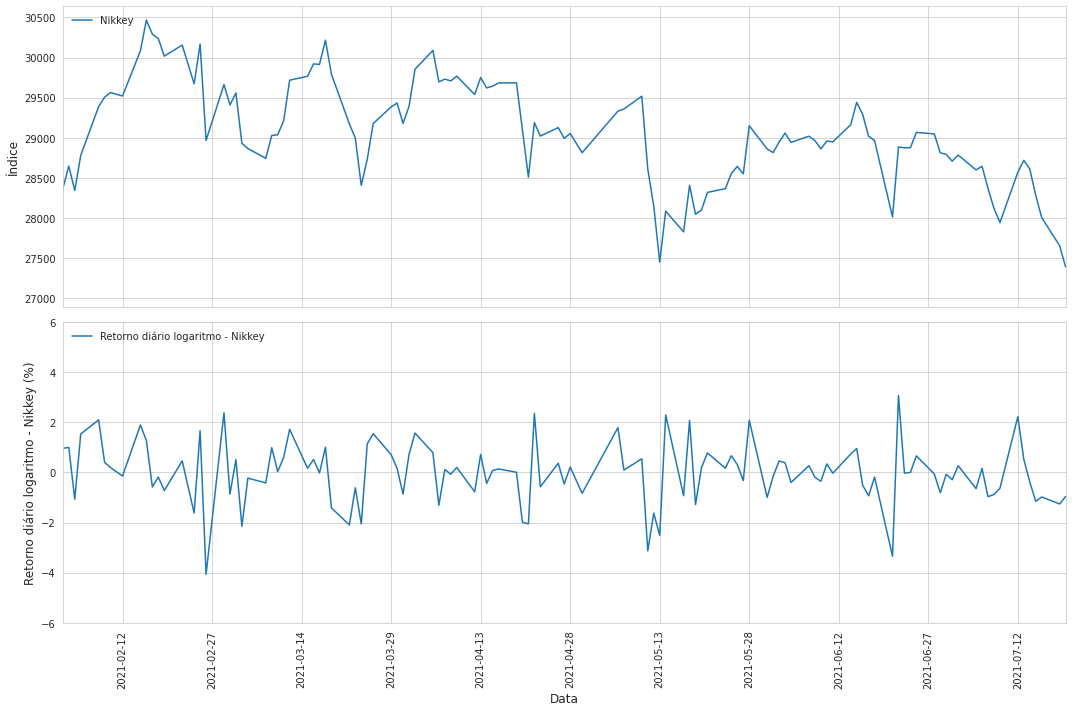

In [89]:
fontsize = 12

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(211)

date_min = df.index.min()
date_max = df.index.max()

ax.plot(df_ticker['Close'], label=ticker)
setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel('Índice', fontsize=fontsize)
ax.legend(loc='upper left', frameon=False)
ax = fig.add_subplot(212, sharex=ax)

ax.plot(df['Close'], label=f"Retorno diário logaritmo - {ticker}")
ax.yaxis.set_label("Data")
ax.xaxis.set_major_locator(plt.MaxNLocator(13))
# ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_ylim(-6, 6)
ax.set_xlim(left=date_min, right=date_max)
ax.set_xlabel('Data', fontsize=fontsize)
ax.set_ylabel(f"Retorno diário logaritmo - {ticker} (%)", fontsize=fontsize)
ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

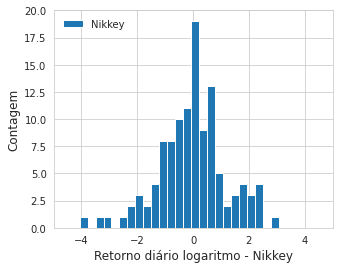

In [90]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

plt.hist(df['Close'], 25,label=ticker, )
ax.set_ylim(0, 20)
ax.set_xlim(-5, 5)
ax.set_ylabel(f"Contagem", fontsize=fontsize)
ax.set_xlabel(f"Retorno diário logaritmo - {ticker}", fontsize=fontsize)
ax.legend(loc='upper left', frameon=False);

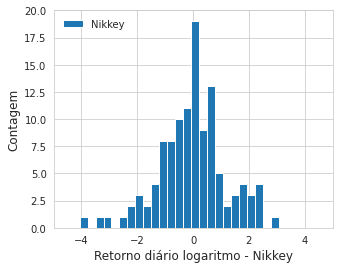

In [91]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

plt.hist(df['Close'], 25,label=ticker, )
ax.set_ylim(0, 20)
ax.set_xlim(-5, 5)
ax.set_ylabel(f"Contagem", fontsize=fontsize)
ax.set_xlabel(f"Retorno diário logaritmo - {ticker}", fontsize=fontsize)
ax.legend(loc='upper left', frameon=False);

In [92]:
lst_cluster = [column for column in df.columns if 'cluster_' in column]

df_clustered = df[lst_cluster].copy()

df_clustered = df_clustered[df_clustered.columns[::-1]]

df_clustered.head()

,cluster_rt-19,cluster_rt-17,cluster_rt-15,cluster_rt-13,cluster_rt-11,cluster_rt-9,cluster_rt-7,cluster_rt-5,cluster_rt-3,cluster_rt-1,cluster_Close
Date,,,,,,,,,,,
2021-02-02,0,1,1,1,0,0,0,0,0,1,1
2021-02-03,0,1,1,0,1,1,1,1,0,1,1
2021-02-04,1,1,1,0,0,0,0,0,1,1,0
2021-02-05,1,1,0,1,1,1,1,0,1,0,1
2021-02-08,1,1,0,0,0,0,0,1,1,1,1


In [93]:
# a = networkx.DiGraph()
# b = lst_cluster.copy()
# b.remove('cluster_Close')
# edges = []

# for item in b:
#     a.add_edge(tuple([df_clustered.columns.get_loc(item)]), tuple([df_clustered.columns.get_loc('cluster_Close')]))
#     edges.append(tuple([item, df_clustered.columns.get_loc('cluster_Close')]))

# print(edges)
# print("Constraint Graph")
# plt.figure(figsize=(10, 8))
# plot_networkx(a)
# plt.show()

Constraint Graph


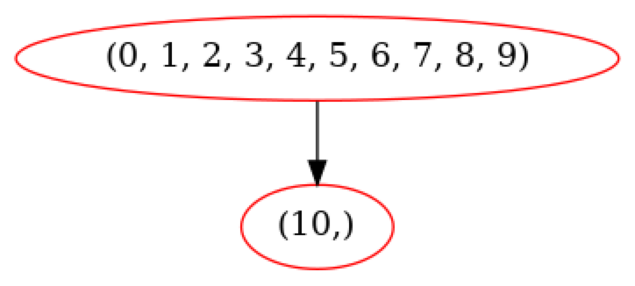

In [94]:
a = networkx.DiGraph()
lst_cluster = [column for column in df_clustered.columns if 'cluster_' in column]
b = lst_cluster.copy()
b.remove('cluster_Close')

lst = [column for column in df_clustered.columns if 'cluster_Close' not in column]
lst = [df_clustered.columns.get_loc(x) for x in lst]

a.add_edge(tuple(lst), tuple([df_clustered.columns.get_loc('cluster_Close')]))

print("Constraint Graph")
plt.figure(figsize=(20, 5))
plot_networkx(a)
plt.show()

In [95]:
# a = networkx.DiGraph()
# lst_cluster = [column for column in df_clustered.columns if 'cluster_' in column]
# b = lst_cluster.copy()
# b.remove('cluster_Close')

# for i in np.arange(len(df_clustered.columns)-1):
#     a.add_edge(tuple([df_clustered.columns.get_loc(lst_inverted[i])]), tuple([df_clustered.columns.get_loc(lst_inverted[i])+1]))

# print("Constraint Graph")
# plt.figure(figsize=(20, 5))
# plot_networkx(a)
# plt.show()

In [96]:
ntest = 20

7 ((), (), (), (), (), (), (), (), (), (), (3, 4))
9 ((), (), (), (), (), (), (), (), (), (), (3, 4))
13 ((), (), (), (), (), (), (), (), (), (), (0, 3))
15 ((), (), (), (), (), (), (), (), (), (), (1, 3))
17 ((), (), (), (), (), (), (), (), (), (), (1, 3))
19 ((), (), (), (), (), (), (), (), (), (), (1, 3, 9))
23 ((), (), (), (), (), (), (), (), (), (), (1, 3))
25 ((), (), (), (), (), (), (), (), (), (), (1, 3))
27 ((), (), (), (), (), (), (), (), (), (), (2, 7))
31 ((), (), (), (), (), (), (), (), (), (), (2, 7))
43 ((), (), (), (), (), (), (), (), (), (), (0, 6))


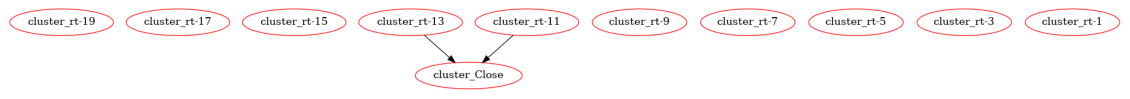

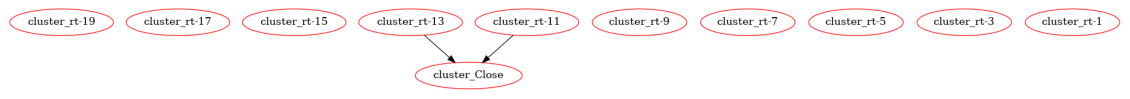

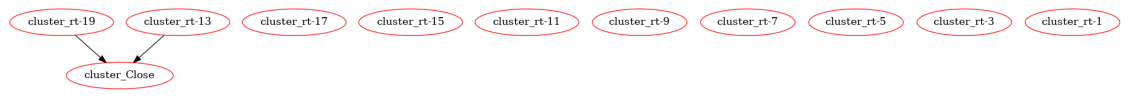

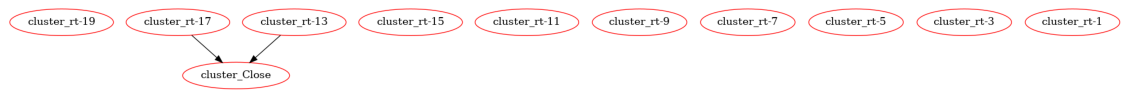

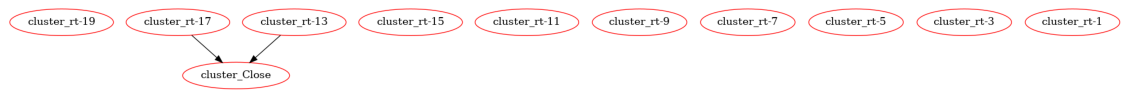

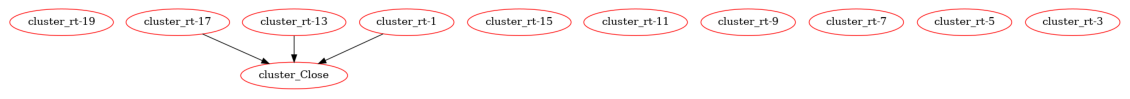

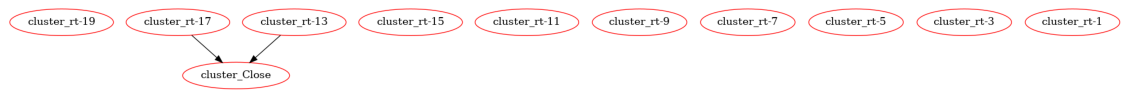

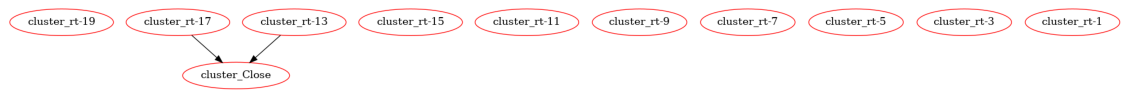

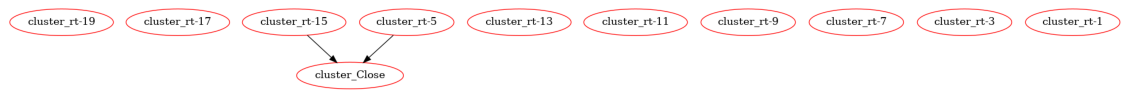

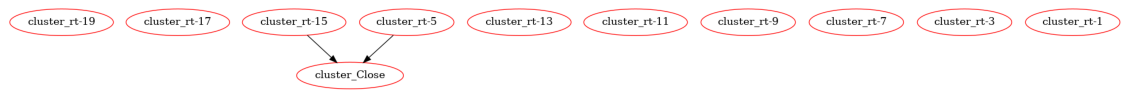

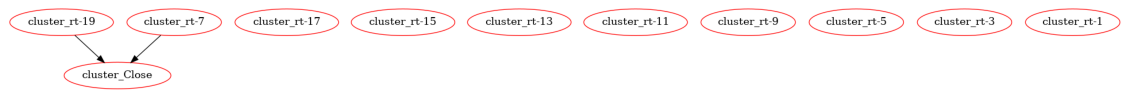

In [97]:
for days_before in np.arange(7, 45, 2):
    model = BayesianNetwork.from_samples(
        df_clustered[-days_before-ntest:-ntest], algorithm='exact', state_names=lst_cluster, reduce_dataset=False, n_jobs=-1,
        constraint_graph=a
    )
    if len(model.structure[-1]) > 1:
        print(days_before, model.structure)
        plt.figure(figsize=(20, 5))
        model.plot()

## Aplicando a mesma lógica aplicada no notebook do ARIMA

In [98]:
%%time

ntotal = df.shape[0]
X_pred = []
X_real = df_clustered[-ntest:]
metrics = {}

for cont in np.arange(7, 45, 2):
    X_train = df_clustered[-ntest-cont:-ntest].copy()
    X_test = df_clustered[-ntest:].copy()
    X_test.iloc[:, -1] = None
    
    print(f"""X_train: {X_train.shape}""")

    model = BayesianNetwork.from_samples(
        X_train, algorithm='exact', state_names=lst_cluster, reduce_dataset=False, n_jobs=-1
        , constraint_graph=a
        )

    
    X_pred = model.predict(X_test.to_numpy())
    
    if len(model.structure[-1]) > 0:
#         plt.figure(figsize=(20, 5))
#         model.plot()
        
        y_pred = []
        for item in X_pred:
            y_pred.append(item[-1])
        
        y_real = X_real.iloc[:,-1].values.tolist()
        
        metrics[cont] = {
            'structure length': model.structure[-1]
            , 'structure': len(model.structure[-1])
            , 'accuracy_score': accuracy_score(y_real, y_pred)
            , 'precision_score': precision_score(y_real, y_pred)
            , 'recall': recall_score(y_real, y_pred)
            , 'f1_score': f1_score(y_real, y_pred)}
        
#         print(f"""
#         DAYS QTY USED FOR TRAINING: {cont}
#         {model.structure}

#         y_real: {y_real}
#         y_pred: {y_pred}
#         accuracy_score: {round(accuracy_score(y_real, y_pred),2)}
#         precision_score: {round(precision_score(y_real, y_pred),2)}
#         recall_score: {round(recall_score(y_real, y_pred),2)}
#         f1_score: {round(f1_score(y_real, y_pred),2)} 
#         """)
        
# X_train: {X_train.shape}
# X_test: {X_test.shape}
# X_pred: ({len(X_pred)}, {len(X_pred[0])})
# y_pred: {len(y_pred)}
# y_real: {len(y_real)}


X_train: (7, 11)
X_train: (9, 11)
X_train: (11, 11)
X_train: (13, 11)
X_train: (15, 11)
X_train: (17, 11)
X_train: (19, 11)
X_train: (21, 11)
X_train: (23, 11)
X_train: (25, 11)
X_train: (27, 11)
X_train: (29, 11)
X_train: (31, 11)
X_train: (33, 11)
X_train: (35, 11)
X_train: (37, 11)
X_train: (39, 11)
X_train: (41, 11)
X_train: (43, 11)
CPU times: user 504 ms, sys: 54.8 ms, total: 558 ms
Wall time: 485 ms


In [99]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.sort_values(by="f1_score", ascending=False).head()
# df_metrics

,structure length,structure,accuracy_score,precision_score,recall,f1_score
27,"(2, 7)",2,0.6,0.375,0.500000,0.428571
31,"(2, 7)",2,0.6,0.375,0.500000,0.428571
15,"(1, 3)",2,0.7,0.500,0.333333,0.400000
17,"(1, 3)",2,0.7,0.500,0.333333,0.400000
19,"(1, 3, 9)",3,0.7,0.500,0.333333,0.400000


<Figure size 1440x360 with 0 Axes>

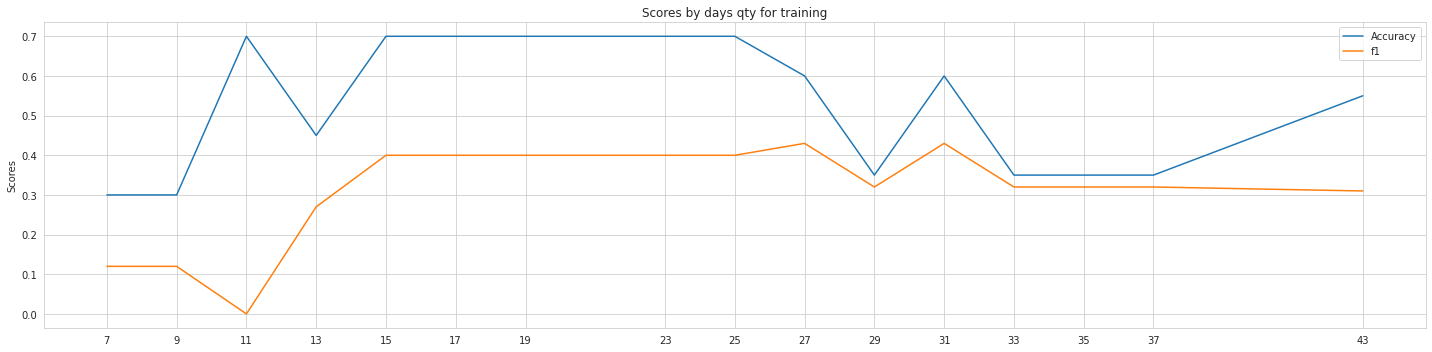

In [100]:
plt.figure(figsize(20,5))

labels = df_metrics.index.tolist()
plt_accuracy_score = round(df_metrics['accuracy_score'], 2)
plt_f1_score = round(df_metrics['f1_score'],2)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, plt_accuracy_score, width, label='Accuracy')
# rects2 = ax.bar(x + width/2, plt_f1_score, width, label='f1')
rects1 = ax.plot(labels, plt_accuracy_score, label='Accuracy')
rects2 = ax.plot(labels, plt_f1_score, label='f1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by days qty for training')
ax.set_xticks(labels)
# ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=1)
# ax.bar_label(rects2, padding=1)

fig.tight_layout()

plt.show();

In [101]:
ntest = 20
h = np.arange(7, 45, 2)
ntotal = df.shape[0]
X_predict = []
X_real = df_clustered[-ntest:]

structrures = []

for horizonte in h:
    print(horizonte)
    
    for cont in np.arange(ntest):
        X_train = df_clustered[-ntest+cont-horizonte:-ntest+cont].copy()
        X_test = df_clustered[-ntest+cont:ntotal-ntest+1+cont].copy()

        model = BayesianNetwork.from_samples(
            X_train, algorithm='exact', state_names=lst_cluster, constraint_graph=a, reduce_dataset=False, n_jobs=-1
        )

        if len(model.structure[-1]) > 1:
            print(model.structure)
            structrures.append(model.structure[-1])
            print(f"""X_train: {X_train.index[-1]}, X_test: {X_test.index[-1]}""")
    #         X_predict.append(model.predict(X_test.to_numpy()))
    #     print(model.predict_proba(X_test.to_numpy()))

7
((), (), (), (), (), (), (), (), (), (), (3, 4))
X_train: 2021-06-22 00:00:00, X_test: 2021-06-23 00:00:00
((), (), (), (), (), (), (), (), (), (), (4, 8))
X_train: 2021-06-23 00:00:00, X_test: 2021-06-24 00:00:00
((), (), (), (), (), (), (), (), (), (), (1, 2))
X_train: 2021-06-28 00:00:00, X_test: 2021-06-29 00:00:00
((), (), (), (), (), (), (), (), (), (), (1, 2))
X_train: 2021-06-29 00:00:00, X_test: 2021-06-30 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 8))
X_train: 2021-06-30 00:00:00, X_test: 2021-07-01 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 2))
X_train: 2021-07-01 00:00:00, X_test: 2021-07-02 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 4))
X_train: 2021-07-02 00:00:00, X_test: 2021-07-05 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 4))
X_train: 2021-07-05 00:00:00, X_test: 2021-07-06 00:00:00
((), (), (), (), (), (), (), (), (), (), (1, 8))
X_train: 2021-07-12 00:00:00, X_test: 2021-07-13 00:00:00
((), (), (), (), (), (), (), (), ()

In [102]:
my_dict = {i:structrures.count(i) for i in structrures}
pd.DataFrame.from_dict(my_dict, orient='index').sort_values(by=0, ascending=False)

,0
"(0, 8)",79
"(5, 8)",41
"(2, 5)",30
"(2, 7)",25
"(8, 9)",16
"(0, 6)",15
"(1, 3)",14
"(0, 4)",9
"(0, 6, 8)",7
"(0, 3)",4


Nikkey:
- (0, 8): 79
- (5, 8): 41
- (2, 5): 30
- (2, 7): 25

0, 2, 5, 7, 8

'cluster_rt-19',
'cluster_rt-15',
'cluster_rt-9',
'cluster_rt-5',
'cluster_rt-3'

 
iBovespa:
- (3, 5): 49
- (2, 5): 27
- (5, 6): 13

'cluster_rt-15'
'cluster_rt-13'
'cluster_rt-9'
'cluster_rt-7'

NYSE:
- (6, 8): 32
- (0, 1): 15

'cluster_rt-19',
'cluster_rt-17',
'cluster_rt-7',
'cluster_rt-3',

In [103]:
X_train.columns.tolist()

['cluster_rt-19',
 'cluster_rt-17',
 'cluster_rt-15',
 'cluster_rt-13',
 'cluster_rt-11',
 'cluster_rt-9',
 'cluster_rt-7',
 'cluster_rt-5',
 'cluster_rt-3',
 'cluster_rt-1',
 'cluster_Close']

In [104]:
lst_nodes = [
'cluster_rt-19',
'cluster_rt-15',
'cluster_rt-9',
'cluster_rt-5',
'cluster_rt-3'
]

lst_pair_nodes = [(item , 'cluster_Close') for item in lst_nodes]
print(lst_pair_nodes)
# [('cluster_rt-15', 'cluster_Close'), ('cluster_rt-13', 'cluster_Close'), ('cluster_rt-9', 'cluster_Close'), ('cluster_rt-7', 'cluster_Close')]

lst_nodes_close = lst_nodes.copy()
lst_nodes_close.append('cluster_Close')
print(lst_nodes_close)

[('cluster_rt-19', 'cluster_Close'), ('cluster_rt-15', 'cluster_Close'), ('cluster_rt-9', 'cluster_Close'), ('cluster_rt-5', 'cluster_Close'), ('cluster_rt-3', 'cluster_Close')]
['cluster_rt-19', 'cluster_rt-15', 'cluster_rt-9', 'cluster_rt-5', 'cluster_rt-3', 'cluster_Close']


# Usando o PGMpy

In [105]:
%%time
ntest = 20
ntotal = 10
# janela = 180
lst_janelas = np.arange(7, 45, 2)

# X_train = df_clustered[:-ntest]
# X_test = df_clustered[-ntest:]
metrics = {}

def predict_model(model, evidence:dict):
    infer = VariableElimination(model)
    proba_predicted = infer.query(['cluster_Close'], evidence=evidence)
    valued_predicted = infer.map_query(['cluster_Close'], evidence=evidence)
    return (valued_predicted, proba_predicted)

resultado = {}  

for janela in lst_janelas:
    X_test = df_clustered[-ntest:]
    resultado = {}
    for i, item in enumerate(X_test.index):
        X_train = df_clustered[-janela-ntest+i:-ntest+i]

        evidence = {
            'cluster_rt-19': X_test.loc[item]['cluster_rt-19'],
            'cluster_rt-15': X_test.loc[item]['cluster_rt-15'],
            'cluster_rt-9': X_test.loc[item]['cluster_rt-9'],
            'cluster_rt-5': X_test.loc[item]['cluster_rt-5'],
            'cluster_rt-3': X_test.loc[item]['cluster_rt-3']
        }
        model = BayesianModel(lst_pair_nodes)
        model.cpds = []
        model.fit(X_train[lst_nodes_close], estimator=BayesianEstimator, prior_type="k2", complete_samples_only=False, n_jobs=-1)

        predict = predict_model(model, evidence=evidence)

        resultado[item] = [predict[0]['cluster_Close'], X_test.loc[item]['cluster_Close']]

    resultado = pd.DataFrame.from_dict(resultado, orient='index')

    resultado.rename(columns={0: 'y_pred', 1: 'cluster_Close'}, inplace=True)

    metrics[janela] = {
        'accuracy_score': accuracy_score(resultado["cluster_Close"], resultado["y_pred"])
        , 'precision_score': precision_score(resultado["cluster_Close"], resultado["y_pred"])
        , 'recall': recall_score(resultado["cluster_Close"], resultado["y_pred"])
        , 'f1_score': f1_score(resultado["cluster_Close"], resultado["y_pred"])}

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.sort_values(by='f1_score', ascending=False)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimin

CPU times: user 38.7 s, sys: 9.7 s, total: 48.4 s
Wall time: 38.2 s


,accuracy_score,precision_score,recall,f1_score
43,0.80,0.750000,0.500000,0.600000
41,0.80,0.750000,0.500000,0.600000
39,0.80,0.750000,0.500000,0.600000
33,0.80,1.000000,0.333333,0.500000
35,0.80,1.000000,0.333333,0.500000
37,0.75,0.666667,0.333333,0.444444
15,0.75,1.000000,0.166667,0.285714
17,0.75,1.000000,0.166667,0.285714
19,0.75,1.000000,0.166667,0.285714
21,0.75,1.000000,0.166667,0.285714


In [106]:
resultado

,y_pred,cluster_Close
2021-06-23,0,0
2021-06-24,1,1
2021-06-25,1,1
2021-06-28,0,0
2021-06-29,0,0
2021-06-30,0,0
2021-07-01,0,0
2021-07-02,0,1
2021-07-05,0,0
2021-07-06,0,1


Finding Elimination Order: : : 0it [01:05, ?it/s]
Finding Elimination Order: : : 0it [01:05, ?it/s]


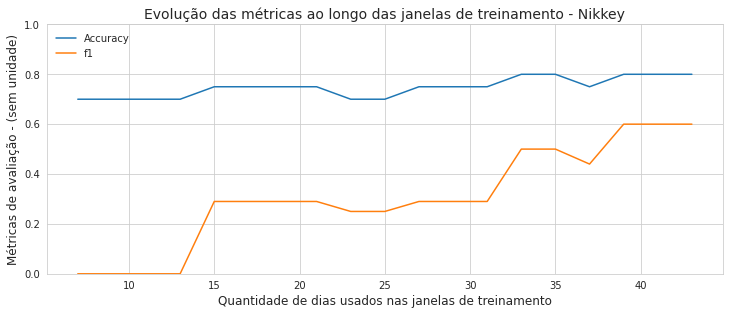

In [107]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

labels = df_metrics.index.tolist()
plt_accuracy_score = round(df_metrics['accuracy_score'], 2)
plt_f1_score = round(df_metrics['f1_score'],2)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

rects1 = ax.plot(labels, plt_accuracy_score, label='Accuracy')
rects2 = ax.plot(labels, plt_f1_score, label='f1')

fig.tight_layout()

ax.set_ylim(0, 1)
# ax.set_xlim(-5, 5)
ax.set_title(f"Evolução das métricas ao longo das janelas de treinamento - {ticker}", fontsize=fontsize+2)
ax.set_ylabel(f"Métricas de avaliação - (sem unidade)", fontsize=fontsize)
ax.set_xlabel(f"Quantidade de dias usados nas janelas de treinamento", fontsize=fontsize)
ax.legend(loc='upper left', frameon=False);

plt.show();

# Entendendo o uso do aprendizado da Rede Bayesiana

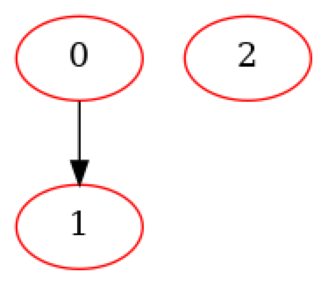

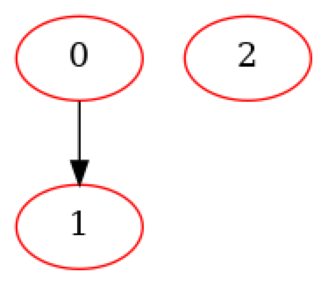

In [23]:
random.seed(RANDOM_SEED)

X = numpy.random.randint(2, size=(20, 3))
X[:,1] = (X[:,0])
# X[:,2] = (X[:,0]+1)

for algorith in ["exact", "greedy"]:
    model = BayesianNetwork.from_samples(X, algorithm=algorith, reduce_dataset=False, n_jobs=-1)
    plt.figure(figsize=(20, 5))
    model.plot()

Constraint Graph


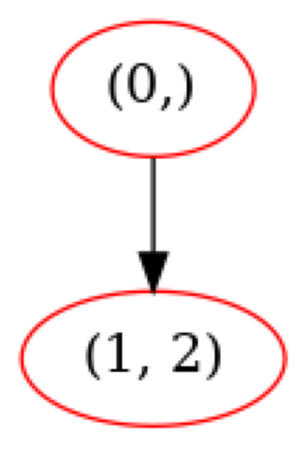

In [24]:
a = networkx.DiGraph()

# a.add_edge(tuple([1, 2]), tuple([0]))
a.add_edge(tuple([0]), tuple([1,2]))

print("Constraint Graph")
plt.figure(figsize=(10, 8))
plot_networkx(a)
plt.show()

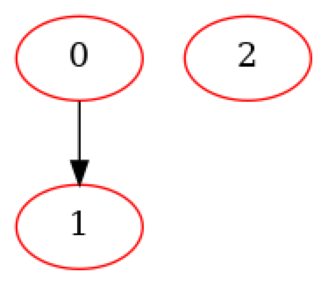

In [25]:
model = BayesianNetwork.from_samples(X, algorithm='exact', reduce_dataset=False
                                     , constraint_graph=a
                                     , n_jobs=-1)

model.bake()
plt.figure(figsize=(20, 5))
model.plot()

In [26]:
X

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [1, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 1, 1],
       [0, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 0, 1],
       [1, 1, 0],
       [1, 1, 0],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 1],
       [0, 0, 0]])

In [27]:
model.predict([[1, None, 1]])

[array([1, 1, 1], dtype=object)]

In [28]:
df = df_ibovespa[["Close"]].copy()
df = daily_return(df)
df.head()

NameError: name 'df_ibovespa' is not defined

In [ ]:
lst_columns = ["Close"]


df_boxplot

In [ ]:
df_boxplot = df.describe().T
quartile_1 = df_boxplot["25%"][0]
quartile_2 = df_boxplot["50%"][0]
quartile_3 = df_boxplot["75%"][0]

for column in lst_columns:
    conditions = [
        (df[column] < quartile_1),
        (df[column] >= quartile_1) & (df[column] < quartile_2),
        (df[column] >= quartile_2) & (df[column] < quartile_3),
        (df[column] >= quartile_3)]

    choices = [1, 2, 3, 4]
    df["cluster_"+column] = np.select(conditions, choices, default=np.nan)